In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline
%config InlineBackend.figure_format='retina'

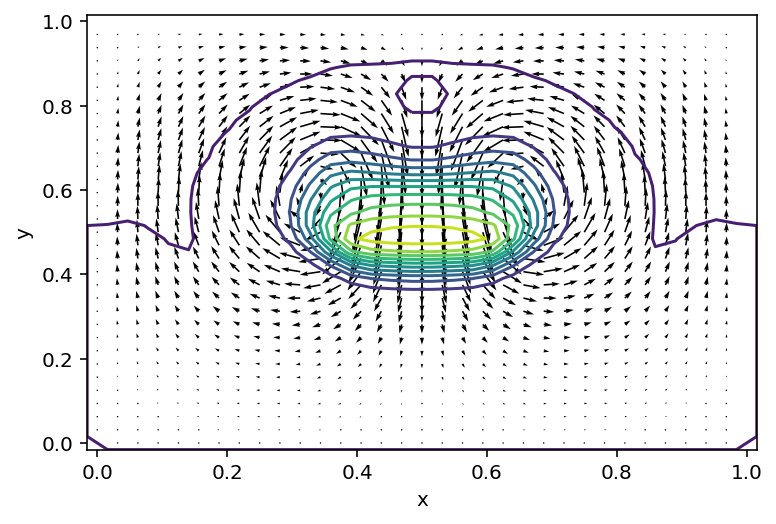

99


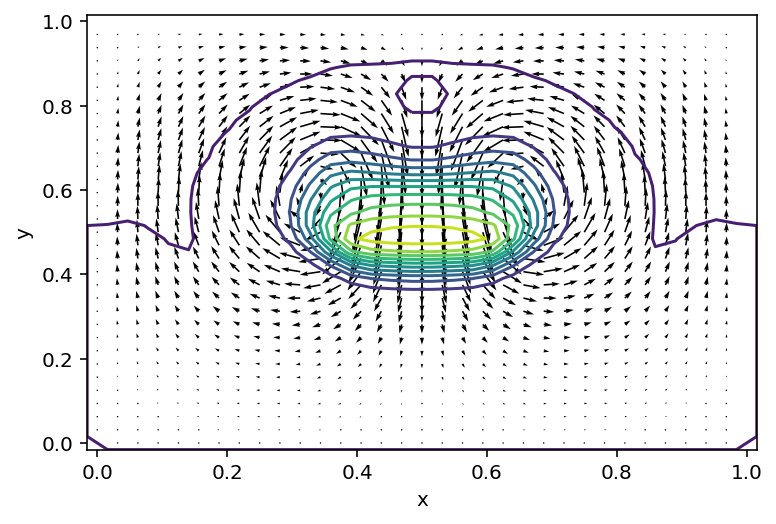

In [25]:
# Domain size and physical variables
Ly = 1.
Lx = 1.
gx = 0
gy = -100.
rho1 = 1.
rho2 = 2.
mu = 0.01

# Tangential velocities
unorth = 0.
usouth = 0.
veast = 0.
vwest = 0.

# Initial drop size and location
rad = 0.15
xc = 0.5
yc = 0.7

# Numerical analysis variables and parameters
nx = 32
ny = 32
dt = 0.00125
nstep = 100
maxiter = 200
maxError = 0.001
beta = 1.2
dx = Lx/nx
dy = Ly/ny

u = np.zeros((nx+1, ny+2))
v = np.zeros((nx+2, ny+1))
p = np.zeros((nx+2, ny+2))

ut = np.zeros_like(u)
vt = np.zeros_like(v)

Ax = np.zeros_like(u)
Dx = np.zeros_like(u)
Ay = np.zeros_like(v)
Dy = np.zeros_like(v)

# temporary variables for the pressure calculations
tmp1 = np.zeros((nx+2, ny+2))
tmp2 = np.zeros((nx+2, ny+2))

# Velocities at the center of the grid for plotting
uu = np.zeros((nx+1, ny+1))
vv = np.zeros((nx+1, ny+1))

x = np.linspace(-0.5*dx, (nx+0.5)*dx, nx+2)
y = np.linspace(-0.5*dy, (ny+0.5)*dy, ny+2)

r = np.ones((nx+2, ny+2))*rho1

# Set initial conditions for density
for i in range(1,nx+1):
    for j in range(1, ny+1):
        if ((x[i]-xc)**2+(y[j]-yc)**2) < rad**2:
            r[i,j] = rho2

time = 0
for step in range(nstep):
    
    # tangential velocities at the ghost cells
    u[:,0] = 2*usouth - u[:,1]
    u[:,-1] = 2*unorth - u[:,-2]
    v[0,:] = 2*vwest - v[1,:]
    v[-1,:] = 2*veast - v[-2,:]
    
    ## Temporary x-velocity MAIN LOOP ##
    for i in range(1,nx):
        for j in range(1,ny+1):
            # Advection matrix
            Ax[i,j] = (0.25/dx*((u[i+1,j]+u[i,j])**2 - (u[i,j]+u[i-1,j])**2) + 
                       0.25/dy*((u[i,j+1]+u[i,j])*(v[i+1,j]+v[i,j]) - 
                             (u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1])))
            # Diffusion matrix
            Dx[i,j] = mu * ((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2 + (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2)
            # Temporary velocity
            ut[i,j] = u[i,j] + dt*(-Ax[i,j] + gx + 2*Dx[i,j]/(r[i+1,j]+r[i,j]))
    
    ## Temporary y-velocity MAIN LOOP ##
    for i in range(1,nx+1):
        for j in range(1,ny):
            # Advection matrix
            Ay[i,j] = (0.25/dx*((u[i,j]+u[i,j+1])*(v[i,j]+v[i+1,j]) -
                       (u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j])) +
                       0.25/dy*((v[i,j+1]+v[i,j])**2 - (v[i,j]+v[i,j-1])**2))
            # Diffusion matrix
            Dy[i,j] = mu * ((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2 + (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2)
            # Temporary velocity
            vt[i,j] = v[i,j] + dt*(-Ay[i,j] + gy + 2*Dy[i,j]/(r[i,j+1]+r[i,j]))
 
            
    # Source term for pressure equation
    rt = np.copy(r)
    lrg = 1000.
    rt[0,:] = lrg
    rt[-1,:] = lrg
    rt[:,0] = lrg
    rt[:,-1] = lrg
    
    # Assemble and compute pressure
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            tmp1[i,j] = 1/(2*dt)*((ut[i,j]-ut[i-1,j])/dx + (vt[i,j]-vt[i,j-1])/dy)
            tmp2[i,j] = 1/((1/dx**2)*(1/(rt[i+1,j]+rt[i,j]) + 1/(rt[i,j]+rt[i-1,j])) + 
                               (1/dy**2)*(1/(rt[i,j+1]+rt[i,j]) + 1/(rt[i,j]+rt[i,j-1])))
    it = 0
    while True:
        pn = np.copy(p)
        it += 1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j] = (1-beta)*p[i,j] + beta*tmp2[i,j]*((1/dx**2*(p[i+1,j]/(rt[i+1,j]+rt[i,j])+p[i-1,j]/(rt[i,j]+rt[i-1,j])) +
                                                       1/dy**2*(p[i,j+1]/(rt[i,j+1]+rt[i,j])+p[i,j-1]/(rt[i,j]+rt[i,j-1])) - tmp1[i,j]))
        if it%100 == 0:
            print(f'Pressure loop iterations: {it}')
        if np.abs(pn-p).max() < maxError:
            print(f'Pressure convergence achieved in {it} iterations.')
            break
        if it > maxiter:
            print(f'Pressure convergence not achieved. Max iterations reached in pressure loop.')
            break

    # Update velocities
    for i in range(1,nx):
        for j in range(1,ny+1):
            u[i,j] = ut[i,j] - 2*dt/dx*(p[i+1,j]-p[i,j])/(r[i+1,j]+r[i,j])
    for i in range(1,nx+1):
        for j in range(1,ny):
            v[i,j] = vt[i,j] - 2*dt/dy*(p[i,j+1]-p[i,j])/(r[i,j+1]+r[i,j])
            
#     # Advect the density
    ro = r.copy()
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            r[i,j] = (ro[i,j] - (0.5*dt/dx)*(u[i,j]*(ro[i+1,j]+ro[i,j]) - u[i-1,j]*(ro[i-1,j]+ro[i,j])) -
                                (0.5*dt/dy)*(v[i,j]*(ro[i,j+1]+ro[i,j]) - v[i,j-1]*(ro[i,j-1]+ro[i,j])) +
                      mu*dt/dx**2*(ro[i+1,j]-2.*ro[i,j]+ro[i-1,j]) + 
                      mu*dt/dy**2*(ro[i,j+1]-2.*ro[i,j]+ro[i,j-1]))

    # Plot the density contour and the velocity field
    uu = 0.5*(u[0:nx,1:ny+1] + u[0:nx,0:ny])
    vv = 0.5*(v[1:nx+1,0:ny] + v[0:nx,0:ny])
    yy, xx = np.mgrid[0:(nx-1)*dx:nx*1j, 0:(ny-1)*dy:ny*1j]
    X, Y = np.meshgrid(x, y)
    plt.clf()
    plt.quiver(xx,yy,uu.T,vv.T)
    plt.contour(x,y,r.T,10)
    plt.xlabel('x')
    plt.ylabel('y')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print(step)  
    time=time+dt
#     #Plot the density contour and the velocity field
#     uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
#     vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
#     yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
#     plt.clf()
#     plt.quiver(xx,yy,uu.T,vv.T)
#     plt.contour(x,y,r.T,10)
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     print(step) 

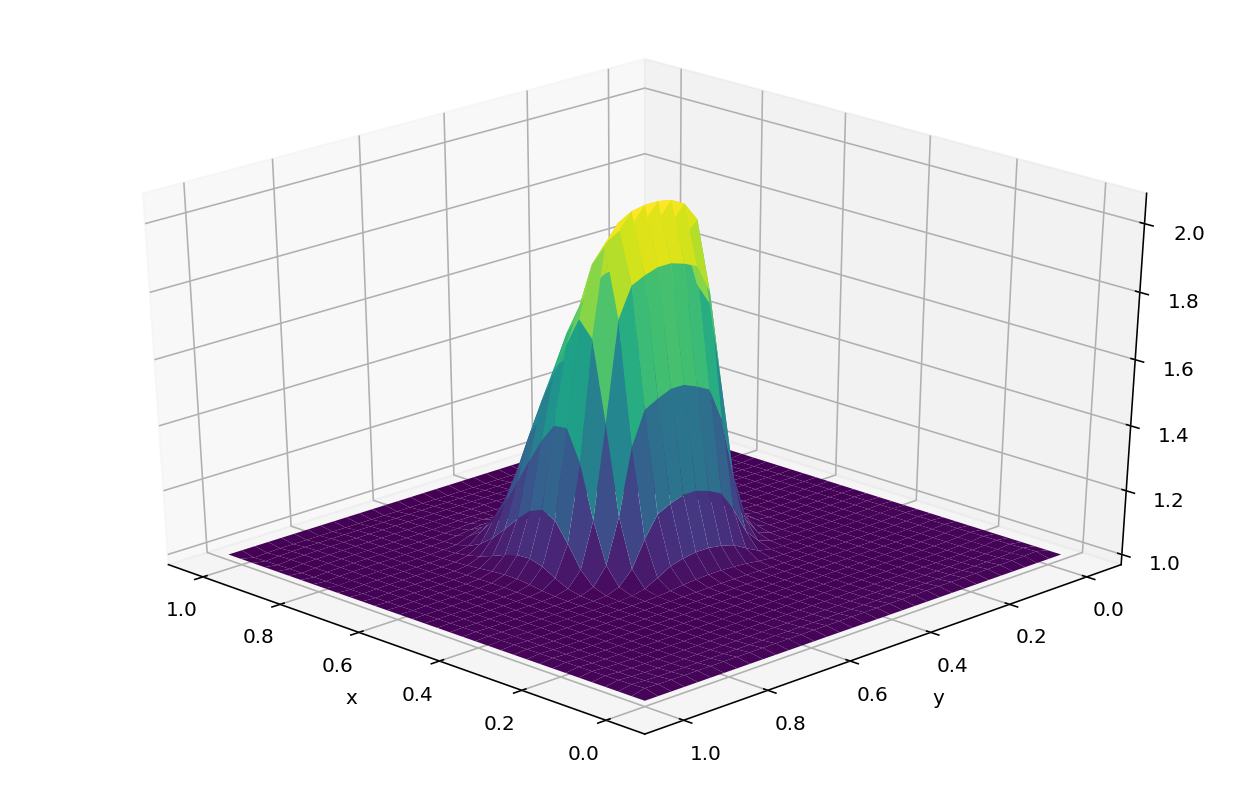

In [40]:
fig = plt.figure(figsize=(11,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, r, cmap=cm.viridis)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(30,135)